## Expectation Reflection for Classification

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
def synthesize_data(l,n,g,data_type='continous'):        
    if data_type == 'binary':
        X = np.sign(np.random.rand(l,n)-0.5)
        w = np.random.normal(0.,g/np.sqrt(n),size=n)
        
    if data_type == 'continuous':
        X = 2*np.random.rand(l,n)-1
        w = np.random.normal(0.,g/np.sqrt(n),size=n)
        
    if data_type == 'categorical':        
        from sklearn.preprocessing import OneHotEncoder
        m = 5 # categorical number for each variables
        # initial s (categorical variables)
        s = np.random.randint(0,m,size=(l,n)) # integer values
        onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
        X = onehot_encoder.fit_transform(s)
        w = np.random.normal(0.,g/np.sqrt(n),size=n*m)
        
    h = X.dot(w)
    p = 1/(1+np.exp(-2*h)) # kinetic
    #p = 1/(1+np.exp(-h))  # logistic regression
    y = np.sign(p - np.random.rand(l))
    return w,X,y

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def ML_inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.0)
        y_pred = ER.predict(X_test,h0,w)
        accuracy = accuracy_score(y_test,y_pred)
        
    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)        
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        accuracy = accuracy_score(y_test,y_pred)
    return accuracy

In [5]:
list_methods=['expectation_reflection','naive_bayes','logistic_regression','decision_tree','random_forest']
def compare_ML_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y_train0)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = ML_inference(X_train,y_train,X_test,y_test,method)
            #print('% 20s :'%method,accuracy)            
        #print(y_train.shape[0],y_test.shape[0])

    return accuracy.mean(axis=1),accuracy.std(axis=1)

### Categorical variables

In [6]:
l = 10000
n = 20
g = 16.

In [7]:
w0,X,y = synthesize_data(l,n,g,data_type='categorical')

In [8]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [9]:
list_train_size = [1.,0.8,0.6,0.4,0.2,0.1,0.05]

acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_ML_inference(X,y,train_size)
    print(train_size,acc[i,:])

(1.0, array([0.980065, 0.956725, 0.980295, 0.69453 , 0.79068 ]))
(0.8, array([0.978835, 0.953445, 0.97898 , 0.693355, 0.789185]))
(0.6, array([0.97646 , 0.94636 , 0.97615 , 0.68698 , 0.788005]))
(0.4, array([0.97396 , 0.935735, 0.97296 , 0.681235, 0.79053 ]))
(0.2, array([0.96609 , 0.910895, 0.962815, 0.668095, 0.78696 ]))
(0.1, array([0.949   , 0.88026 , 0.94304 , 0.649785, 0.77719 ]))
(0.05, array([0.911575, 0.835945, 0.90595 , 0.634205, 0.75603 ]))


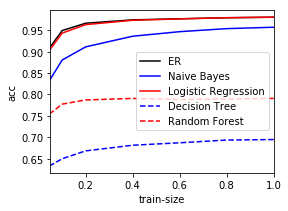

In [10]:
plt.figure(figsize=(4,3))
plt.plot(list_train_size,acc[:,0],'k-',label='ER')
plt.plot(list_train_size,acc[:,1],'b-',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r-',label='Logistic Regression')
plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc[:,4],'r--',label='Random Forest')
plt.xlabel('train-size')
plt.ylabel('acc')
plt.xlim([0.05,1])
#plt.ylim([0.8,1])
plt.legend()